**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (HashingVectorizer)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re
# import gzip

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
sklearn.__version__

'0.23.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [5]:
data.sample(2)

,text,tag
561,В Кобринском районе 24-летний парень погиб в лобовом столкновении Ford и ГАЗ\n\n2 декабря 2016 в 20:59\n\nTUT.BY\n\nУтром 2 декабря в Кобринском районе Ford Mondeo врезался во встречный ГАЗ.\n\n20...,incident
1965,Деловая британская газета Financial Times назвала избранного президента США Дональда Трампа «человеком года».\n\n«Он переписал правила американской политики. Теперь президент-организатор сделок по...,politics


## токенизация и очистка

In [6]:
# NOUN	имя существительное	хомяк
# ADJF	имя прилагательное (полное)	хороший
# ADJS	имя прилагательное (краткое)	хорош
# COMP	компаратив	лучше, получше, выше
# VERB	глагол (личная форма)	говорю, говорит, говорил
# INFN	глагол (инфинитив)	говорить, сказать
# PRTF	причастие (полное)	прочитавший, прочитанная
# PRTS	причастие (краткое)	прочитана
# GRND	деепричастие	прочитав, рассказывая
# NUMR	числительное	три, пятьдесят
# ADVB	наречие	круто
# NPRO	местоимение-существительное	он
# PRED	предикатив	некогда
# PREP	предлог	в
# CONJ	союз	и
# PRCL	частица	бы, же, лишь
# INTJ	междометие	ой

In [7]:
# https://pymorphy2.readthedocs.io
from pymorphy2 import MorphAnalyzer

# лематизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''

def string_normalizer(s):
    return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

def text_normalizer(s):
    return [ word_normalizer(w) for w in string_normalizer(s).split() ]

In [8]:
data['ctext'] = data['text'].progress_apply(text_normalizer).progress_apply(' '.join)

100%|██████████| 3196/3196 [00:00<00:00, 135652.01it/s]


In [9]:
data.sample(10)

,text,tag,ctext
3135,"Север ДВ (severdv.ru) В селе Гадля Ольского района работает детский\nэтнокультурный лагерь ""Нёлтэн Хедекэн"" В лагере завершается трехгодичный\nэксперимент по погружению детей в языковую, культурну...",culture,север сель ольский район работать детский этнокультурный лагерь лагер завершаться эксперимент погружение ребёнок языковой культурный среда коренной малочисленный народ север магадан ию...
2600,"Международным союзом охраны природы был обновлен список редких птиц 740 разновидностями птиц. Из них 13 видов птиц признаны вымершими, более 10% находятся на грани исчезновения.\n\nЮлия Афанасьева...",science,международный союз охрана природа быть список редкий птица разновидность птица вид птица находиться грань исчезновение юлий афанасьев учёный констатировать динамик исчезновение редкий ...
3008,"В списке присутствуют как дорогие, так и массовые модели седанов.\n\nТак, четырехдверка Lincoln Continental окажется не доступной для россиян, так как её минимальная цена составляет 44 тысячи долл...",auto,список присутствовать дорогой массовый модель седан оказаться доступный россиянин минимальный цена составлять тысяча доллар учёт необходимость адаптация тот число необходимость ...
520,"В Барановичах на пешеходном переходе ГАЗ-53 из-за заноса ""уткнулся"" в 8-летнего ребенка\n\n7 декабря 2016 в 21:03\n\nTUT.BY\n\nВ Барановичах грузовик зацепил ребенка, который переходил дорогу по п...",incident,баран пешеходный переход газ занос уткнуться летний ребёнок декабрь баран грузовик зацепить ребёнок который переходить дорога пешеходный переход дтп произойти декабрь предвари...
2247,17:43 12 декабря 2016 21\n\nВместо остановки по требованию ребенка высадили практически в лесу Фото: Вадим Ахметов © URA.Ru\n\nВодитель автобуса №77 в Перми не остановился на остановке по требован...,incident,декабрь остановка требование ребёнок высадить леса фото вадим ахмет водитель автобус пермь остановиться остановка требование маленький пассажир итог мальчик высадить мороз лесн...
109,"ЦСКА переиграл болгарский клуб ""Левски"" со счетом 2:1 В рамках розыгрыша\nКубка УЕФА московский ЦСКА не без труда переиграл болгарский клуб ""Левски""\nсо счетом 2:1...",sport,цска переиграть болгарский клуб счёт рамка розыгрыш кубок уефа московский цска труд переиграть болгарский клуб счёт
1180,"Встретить Новый год в столице: вилла ""Каменная горка"" — 6000 рублей, в ""Доме Чижа"" — 3000\n\n6 декабря 2016 в 9:02\n\nЕлена Зуева / REALTY.TUT.BY\n\nПо традиции в канун Нового года цены на аренду ...",realty,новый год столица вилла каменный горка рубль дом чиж декабрь елена зуев традиция канун новое год цена аренда коттедж подниматься раз останавливать тот хотеть праздник прир...
542,"ДТП под Ханты-Мансийском: водитель автобуса за два года семь раз привлекался за нарушение ПДД\n\n5 декабря 2016 в 12:20\n\nMeduza\n\nСтали известны подробности автокатастрофы под Ханты-Мансийском,...",incident,дтп ханты мансийский водитель автобус год раз привлекаться нарушение декабрь стать подробность автокатастрофа ханты мансийский который погибнуть человек тот число ребёнок челов...
2467,Этот случай едва не заставил мужчину навсегда отказаться от перевоплощений в Санта-Клауса.\n\nТрагичная история произошла в американском штате Теннесси в начале зимы: смертельно больной мальчик ск...,culture,этот случай заставить мужчина перевоплощение клаус трагичный история произойти американский штат начало зима больной мальчик скончаться рука клаус этот история рассказать журналист т...
52,"Новое лекарство от СПИДа появится через год... вирус иммунного дефицита,\nсообщил о том, что он достиг определенных успехов в создании вакцины от\nСПИДа и надеется начать ее клинические испытания ...",health,новое лекарство спид появиться год вирус иммунный дефицит сообщить тот достигнуть определённый успех создание вакцина спид надеяться клинический испытание доктор роберт директор инсти...


---

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer().fit(data['ctext'])
print( 'словарь:', len(count.vocabulary_), 'слов\n')  
pd.DataFrame( sorted(count.vocabulary_.keys()) ).to_csv('voc.txt',index=False,header=False)

словарь: 22128 слов



##  Vectorizer

In [11]:
from sklearn.feature_extraction.text import HashingVectorizer

tf = HashingVectorizer( n_features=65536, norm='l2' ).fit( data['ctext'] )

## формируем датасеты

In [12]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 65536)

In [13]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [14]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 65536), (319,), (2877, 65536), (2877,))

## обучаем

In [16]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [17]:
o = clf.predict(X_train)

In [18]:
accuracy_score(y_train,o)

1.0

In [19]:
o = clf.predict(X_test)

In [20]:
accuracy_score(y_test,o)

0.7490441432047271

In [21]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       227
           1       0.74      0.77      0.76       319
           2       0.61      0.81      0.70       240
           3       0.46      0.14      0.21        86
           4       0.87      0.78      0.82       396
           5       0.75      0.89      0.81       542
           6       0.66      0.36      0.47        58
           7       0.41      0.44      0.42        41
           8       0.66      0.91      0.76       200
           9       0.57      0.24      0.34       133
          10       0.94      0.90      0.92       340
          11       0.73      0.66      0.70       262
          12       0.00      0.00      0.00        33

    accuracy                           0.75      2877
   macro avg       0.63      0.59      0.59      2877
weighted avg       0.74      0.75      0.73      2877



---

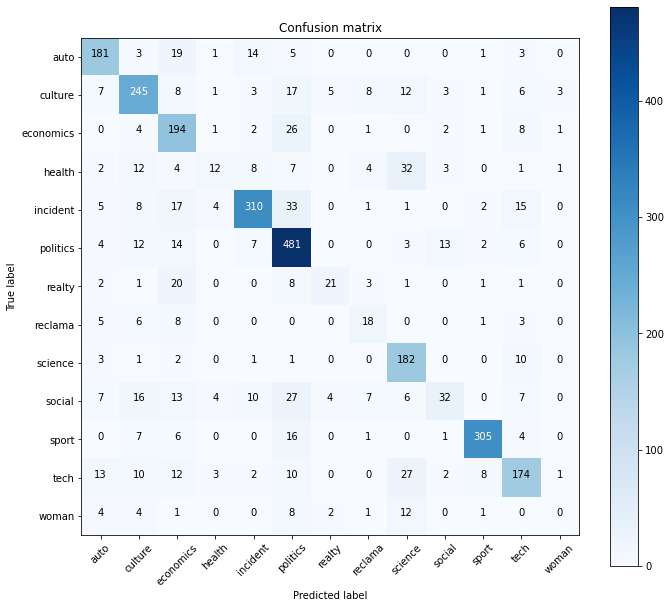

In [22]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [23]:
o = clf.predict(X)

In [24]:
labels_inv = { labels[k]:k for k in labels}
# labels_inv

In [25]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: sport
predict: sport
МОСКВА, 13 декабря. /ТАСС/. "Вильярреал" крупно победил мадридский "Атлетико" в домашнем матче 15-го тура чемпионата Испании по футболу. Встреча завершилась со счетом 3:0. Мячи забили Мануэль Тригеро...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Лидер Радикальной партии Олег Ляшко раскритиковал депутата Верховной рады Украины от партии «Батькивщина» Надежду Савченко за встречу с главами самопровозглашенных Донецкой и Луганской народных респуб...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
На своей странице в "фейсбуке" Ляшко назвал поступок Савченко государственной изменой и предложил запретить ей доступ к гостайне, отозвать из ПАСЕ и лишить депутатского мандата. — То, что сейчас чуди...
- - - - - - - - - - - - - - - - - -
tag: culture
predict: woman
Ноксвилл, штат Теннесси, 13 декабря. Получив звонок из местной больницы, в котором его просили навестить смертельно больного пятилетнего мальчика, который как заяви

In [26]:
# https://habr.com/ru/post/205360/